In [1]:
include("../source/spin-1_XY_ED.jl")

odlro_matrix (generic function with 1 method)

#### 1) When $ J_2 = 0 $ 

In [2]:
N = 8
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false
basis_list = gen_basis_full_1D(N)

time_list::Vector{Float64} = Vector{Float64}((LinRange(0,40,800)))
n_t = length(time_list)
t_step = time_list[2]-time_list[1];

In [3]:
@time begin
    top_folder = joinpath("D:\\IACS_Project\\spin-1_XY\\data\\1D\\spin-1_XY_N=$(N)\\unperturbed\\OBC")
    neel_evolved_file = joinpath(top_folder,"neel_t_evolved_state",
    "evolved_state_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6))_tstep=$(round(t_step,digits=6)).jld2")
    ferro_evolved_file = joinpath(top_folder,"ferro_t_evolved_state",
    "evolved_state_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6))_tstep=$(round(t_step,digits=6)).jld2")
    neel_evolved_state_list = JLD2.load(neel_evolved_file)["evolved_state_list"]
    ferro_evolved_state_list = JLD2.load(ferro_evolved_file)["evolved_state_list"]
end;

  4.340650 seconds (1.23 M allocations: 243.288 MiB, 3.61% gc time, 44.23% compilation time: 90% of which was recompilation)


In [8]:
r = 2
basis_new = similar(basis_list[1])

@time begin
    S_plus_sq_matrix,nematic_matrix_size = S_plus_sq(r,basis_list,basis_new)
    S_minus_sq_matrix,nematic_matrix_size = S_minus_sq(r,basis_list,basis_new)
end;

  0.227827 seconds (13.20 k allocations: 2.353 MiB)


##### $ \langle O_r \rangle = \frac{1}{2} \langle [(S_r^+)^2+(S_r^-)^2] \rangle $

In [9]:
outvect::Vector{ComplexF64} = Vector{ComplexF64}(undef,nematic_matrix_size)
neel_plus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)
ferro_plus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)
neel_minus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)
ferro_minus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)

@time begin
    for i in 1:n_t
        neel_t_evolved_state = neel_evolved_state_list[i]
        mul!(outvect,S_plus_sq_matrix,neel_t_evolved_state)
        neel_plus_director_list[i] = (dot(neel_t_evolved_state,outvect))
        mul!(outvect,S_minus_sq_matrix,neel_t_evolved_state)
        neel_minus_director_list[i] = (dot(neel_t_evolved_state,outvect))
        
        ferro_t_evolved_state = ferro_evolved_state_list[i]
        mul!(outvect,S_plus_sq_matrix,ferro_t_evolved_state)
        ferro_plus_director_list[i] = (dot(ferro_t_evolved_state,outvect))
        mul!(outvect,S_minus_sq_matrix,ferro_t_evolved_state)
        ferro_minus_director_list[i] = (dot(ferro_t_evolved_state,outvect))
    end
end

average_nematic_neel_director_list = [(abs(imag(x))<1e-6 ? real(x) : x) 
                                      for x in (neel_plus_director_list+neel_minus_director_list)/2]

average_nematic_ferro_director_list = [(abs(imag(x))<1e-6 ? real(x) : x) 
                                      for x in (ferro_plus_director_list+ferro_minus_director_list)/2];

  1.004690 seconds (4.58 k allocations: 134.062 KiB)


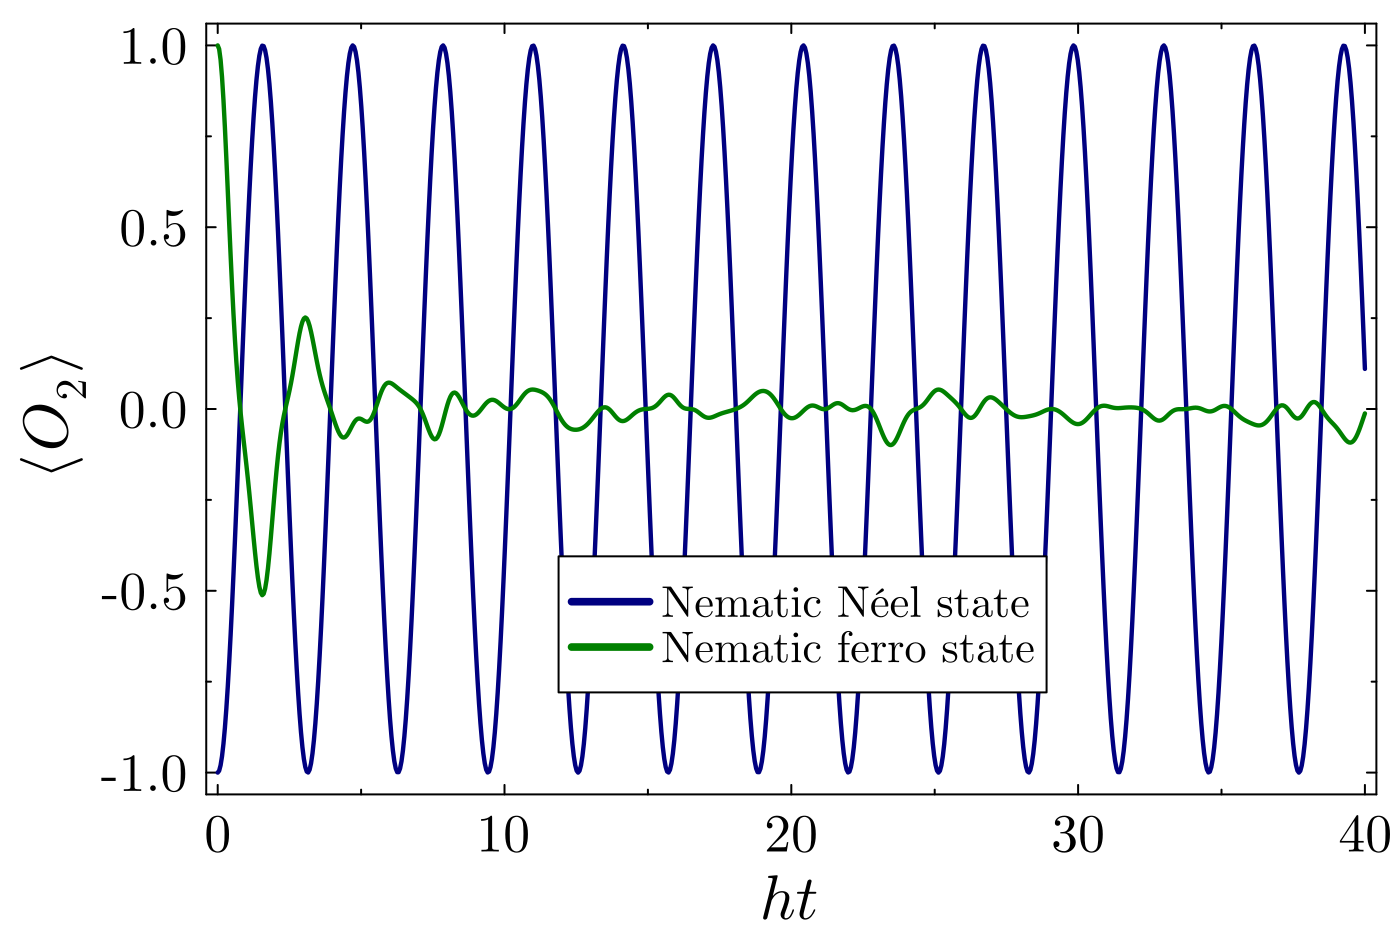

"D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=8\\unperturbed\\OBC\\Nematic_directors_r=2_J1=1.0_J3=0.1_D=0.1_h=1.0.png"

In [10]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

# Set the figure size
plot_size = (700,466.67)
default(fontfamily="Computer Modern")

# Define the plot
p = plot(h*time_list,average_nematic_neel_director_list,lw=2.2,c=:navy,label="Nematic Néel state",size=plot_size,dpi=200)
plot!(h*time_list,average_nematic_ferro_director_list,lw=2.2,c=:green,label="Nematic ferro state")

plot!(left_margin=4mm,right_margin=1mm,top_margin=1mm,bottom_margin=2mm)
plot!(framestyle=:box)
plot!(legend_position=(0.39,0.25),legendfontsize=14,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=21)
ylabel!("\$\\langle O_{$r}\\rangle\$",guidefontsize=21)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0,10,40
y1,y_step,y2 = -1,0.5,5
xticks = (x1:x_step:x2,string.(x1:x_step:x2))
yticks = (y1:y_step:y2,string.(y1:y_step:y2))
xminor_ticks = 2
yminor_ticks = 2
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=17,tick_direction=:in)
plot!(xlims=(-0.4,x2+0.4))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\unperturbed\\$(boundary)"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Nematic_directors_r=$(r)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

#### 2) When $ J_2 \neq 0 $ 

In [4]:
N = 8
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false
basis_list = gen_basis_full_1D(N)
neel_state = nematic_neel_1D(N,basis_list)

time_list::Vector{Float64} = Vector{Float64}((LinRange(0,400,4000)))
n_t = length(time_list)
t_step = time_list[2]-time_list[1];

In [9]:
@time begin
    J2_list::Vector{Float64} = Vector{Float64}([0.01,0.02,0.03,0.05,0.07,0.116667])
    J2_neel_evolved_state_list = Vector{Vector{Vector{ComplexF64}}}(undef,length(J2_list))
    
    for (pos,J2) in enumerate(J2_list)
        top_folder = joinpath("D:\\IACS_Project\\spin-1_XY\\data\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\OBC")
        neel_evolved_file = joinpath(top_folder,"neel_t_evolved_state",
        "evolved_state_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_J2=$(round(J2,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6))_tstep=$(round(t_step,digits=6)).jld2")
        neel_evolved_state_list = JLD2.load(neel_evolved_file)["evolved_state_list"]
        J2_neel_evolved_state_list[pos] = neel_evolved_state_list
    end    
end;

 23.642200 seconds (699.70 k allocations: 2.373 GiB, 10.53% gc time, 0.02% compilation time)


In [17]:
r = 3
basis_new = similar(basis_list[1])

@time begin
    S_plus_sq_matrix,nematic_matrix_size = S_plus_sq(r,basis_list,basis_new)
    S_minus_sq_matrix,nematic_matrix_size = S_minus_sq(r,basis_list,basis_new)
end;

  0.232221 seconds (13.20 k allocations: 2.353 MiB)


##### $ \langle O_r \rangle = \frac{1}{2} \langle [(S_r^+)^2+(S_r^-)^2] \rangle $

In [18]:
outvect::Vector{ComplexF64} = Vector{ComplexF64}(undef,nematic_matrix_size)

@time begin
    J2_neel_director_list::Vector{Vector{Float64}} = Vector{Vector{Float64}}(undef,length(J2_list))
    
    for (pos,J2) in enumerate(J2_list)
        neel_plus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)
        neel_minus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)
        neel_evolved_state_list = J2_neel_evolved_state_list[pos]
        for i in 1:n_t
            neel_t_evolved_state = neel_evolved_state_list[i]
            mul!(outvect,S_plus_sq_matrix,neel_t_evolved_state)
            neel_plus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
            mul!(outvect,S_minus_sq_matrix,neel_t_evolved_state)
            neel_minus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
        end
        average_nematic_neel_director_list = [(abs(imag(x))<1e-6 ? real(x) : x) 
                                      for x in (neel_plus_director_list+neel_minus_director_list)/2]
        J2_neel_director_list[pos] = average_nematic_neel_director_list
    end
end;

  0.905703 seconds (197.79 k allocations: 7.626 MiB, 8.58% compilation time)


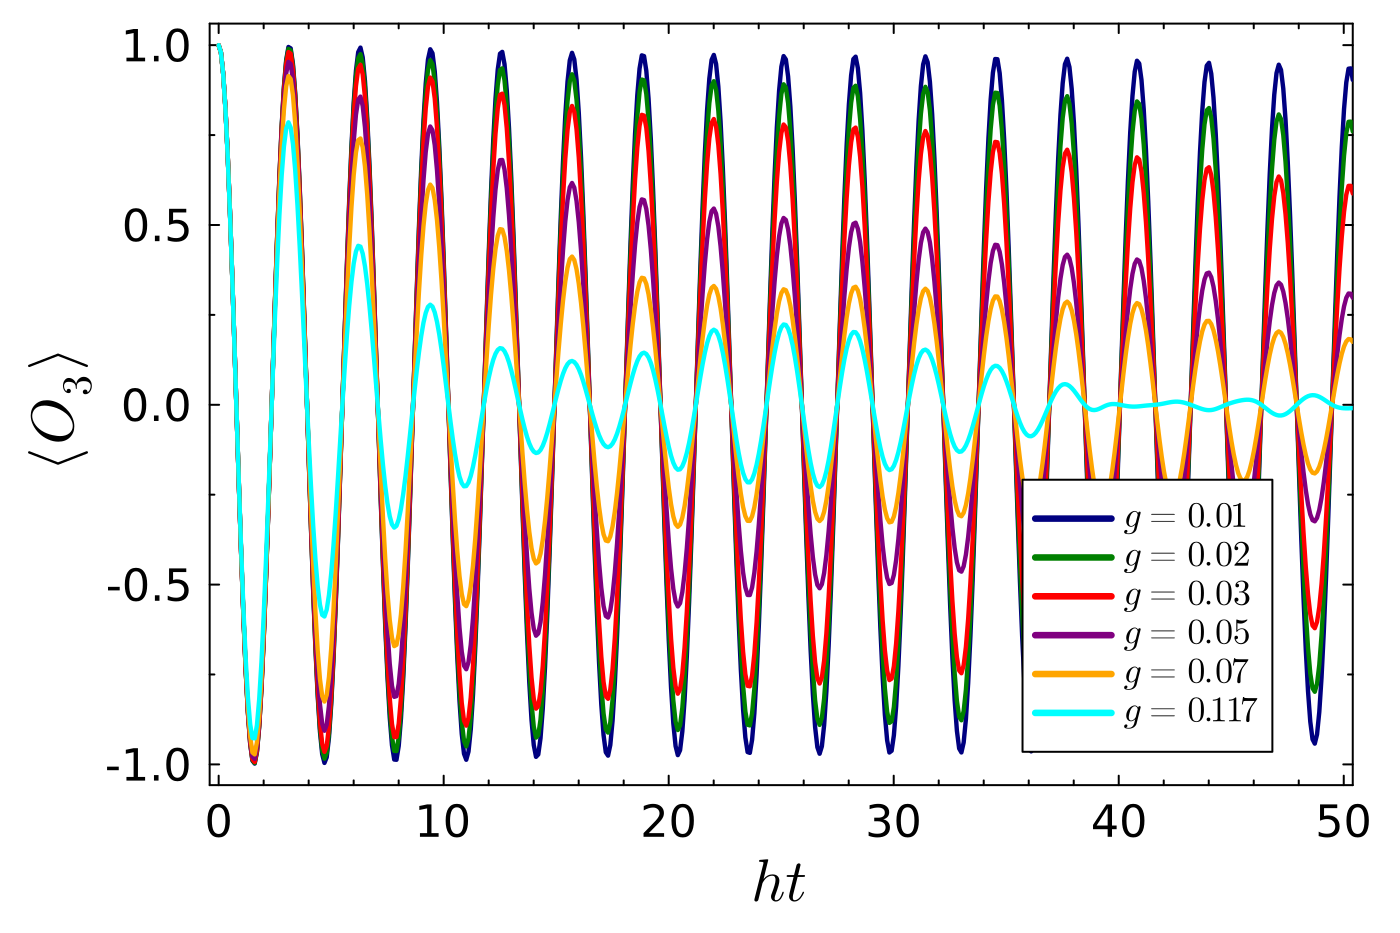

"D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=8\\sec_nbr_perturbed\\OBC\\Nematic_directors_r=3_J1=1.0_J3=0.1_D=0.1_h=1.0.png"

In [19]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

# Set the figure size
plot_size = (700,466.67)

J2_1 = round(J2_list[1],digits=3)
J2_2 = round(J2_list[2],digits=3)
J2_3 = round(J2_list[3],digits=3)
J2_4 = round(J2_list[4],digits=3)
J2_5 = round(J2_list[5],digits=3)
J2_6 = round(J2_list[6],digits=3)

# Define the plot
p = plot(h*time_list,J2_neel_director_list[1],lw=2.2,c=:navy,label="\$g=$(J2_1)\$",size=plot_size,dpi=200)
plot!(h*time_list,J2_neel_director_list[2],lw=2.2,c=:green,label="\$g=$(J2_2)\$")
plot!(h*time_list,J2_neel_director_list[3],lw=2.2,c=:red,label="\$g=$(J2_3)\$")
plot!(h*time_list,J2_neel_director_list[4],lw=2.2,c=:purple,label="\$g=$(J2_4)\$")
plot!(h*time_list,J2_neel_director_list[5],lw=2.2,c=:orange,label="\$g=$(J2_5)\$")
plot!(h*time_list,J2_neel_director_list[6],lw=2.2,c=:cyan,label="\$g=$(J2_6)\$")

plot!(left_margin=5mm,right_margin=4mm,top_margin=1mm,bottom_margin=4mm)
plot!(framestyle=:box)
plot!(legend_position=(0.8,0.35),legendfontsize=12,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=20)
ylabel!("\$\\langle O_{$r}\\rangle\$",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0,10,50
y1,y_step,y2 = -1,0.5,5
xticks = (x1:x_step:x2,string.(x1:x_step:x2))
yticks = (y1:y_step:y2,string.(y1:y_step:y2))
xminor_ticks = 5 
yminor_ticks = 2
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:in)
plot!(xlims=(-0.4,x2+0.4))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Nematic_directors_r=$(r)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)